In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
param_adim = {"V": 1.0, "L": 0.025, "rho": 1.2}

In [4]:
df = pd.read_csv('data/data_john_1_case_1.csv')

In [5]:
df_modified = df[
    df['Points:2']==0
]

In [6]:
df_modified.shape

(6492896, 8)

In [7]:
df.shape

(12985792, 8)

In [8]:
x = df_modified['Points:0'].to_numpy()
y = df_modified['Points:1'].to_numpy()
t = df_modified['Time'].to_numpy()
u = df_modified['Velocity:0'].to_numpy()
v = df_modified['Velocity:1'].to_numpy()
p = df_modified['Pressure'].to_numpy()

In [9]:
masque_close = ((x**2 + y**2) < 1.1*(0.025/2)**2)

In [19]:
def true_cl(num, case, time_init, time_max):
    """
    Args:
        num (int): Le numéro du modèle
        case (int): Le numéro du case
        time_init (float): le temps initial 
        time_max (float): le temps max


    Returns:
        time (np.array):  les valeurs de temps
        cl (np.array): la valeur de cl à ces temps
    """
    df = pd.read_csv(f'results_Cl/model_{num}_case_{case}/Cl.csv', index_col=False)
    df_modified = df[((df.iloc[:, 2] > time_init) & (df.iloc[:, 2] < time_max))]
    time = df_modified.iloc[:, 2].to_numpy()
    cl = df_modified.iloc[:, 1].to_numpy()
    return time, cl

In [20]:
def find_cl_data(num, case, time_init, time_max, param_adim, r=0.025/2):
    df = pd.read_csv('data/'+ f"data_john_{num}_case_{case}.csv")
    df_modified = df.loc[
            (df["Time"] > time_init)
            & (df["Time"] < time_init + 15 * (time_max- time_init))
            & (df["Points:2"] == 0.0)
            & (df["Points:0"] ** 2 + df["Points:1"] ** 2 < 1.1* (0.025 / 2) ** 2),
            :,
        ].copy()
    plt.scatter(df_modified['Points:0'].to_numpy(), df_modified['Points:1'].to_numpy(), marker = '.')
    X_theta = np.empty((df_modified.shape[0], 3))
    X_theta[:, 0] = time_init + ((df_modified['Time'].to_numpy() - time_init) % (time_max- time_init) )    #X_full[masque_theta][:, 2] 
    X_theta[:, 2] = df_modified['Pressure'].to_numpy()    #U_full[masque_theta][:, 2]
    X_theta[:, 1] = np.atan2(df_modified['Points:1'].to_numpy(), df_modified['Points:0'].to_numpy())    #np.atan2(X_full[masque_theta][:, 1] * mean_std['y_std'] + mean_std['y_mean'], X_full[masque_theta][:, 0] * mean_std['x_std'] + mean_std['x_mean'])
    portance = np.empty(np.unique(X_theta[:, 0]).shape[0])
    for nb, time_ in enumerate(np.unique(X_theta[:, 0])):
        masque_time = X_theta[:, 0] == time_
        indices = np.argsort(X_theta[masque_time][:, 1])[::-1]
        d_theta = X_theta[masque_time][indices][:-1, 1] - X_theta[masque_time][indices][1:, 1]
        portance[nb] = -np.sum(X_theta[masque_time][indices][1:, 2] * np.sin(X_theta[masque_time][indices][1:, 1])*d_theta * r)
    time_predict = np.unique(X_theta[:, 0])    # (X_full[masque_theta][:, 2].unique()* mean_std['t_std'] + mean_std['t_mean']) * (param_adim['L']/ param_adim['V'])
    return time_predict, portance / (0.5 * param_adim['rho'] * param_adim['V']**2 * 2 * r)

In [21]:
w = np.pi * (261.39/1.57)**0.5
T = np.pi * 2 / w

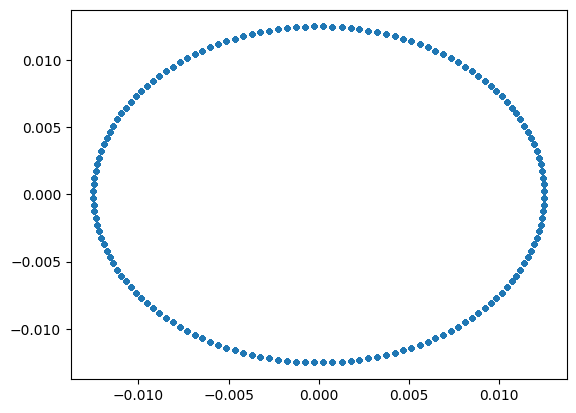

In [22]:
time_data, cl_data = find_cl_data(num=1, case=1, time_init=6., time_max=6.+T, param_adim=param_adim)
time, cl_true = true_cl(num=1, case=1, time_init=6., time_max=6.+T)

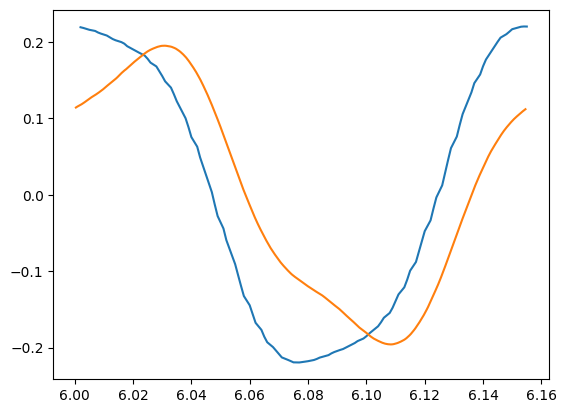

In [24]:
plt.plot(time_data, cl_data)
plt.plot(time, cl_true)

In [25]:
# On essaye d'intégrer proprement 

In [26]:
print(f"La période est de {T:.1e}s")

La période est de 1.6e-01s


In [27]:
time_init = 6.
time_max = time_init + T
r = 0.025/2
rho = 1.2
V = 1.

In [28]:
time, cl_true = true_cl(num=1, case=1, time_init=time_init, time_max=time_max)

Text(0.5, 1.0, "Courbe de Cl qu'on veut reproduire")

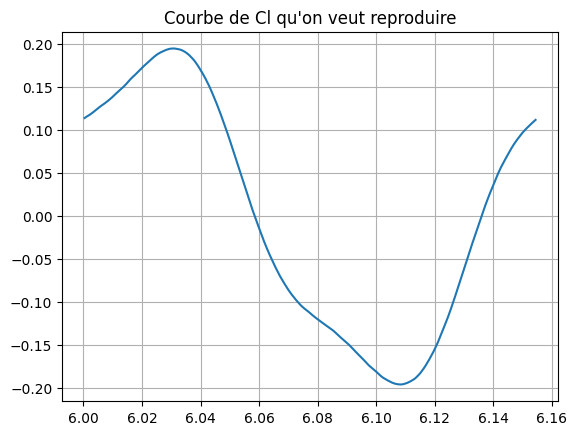

In [29]:
plt.plot(time, cl_true)
plt.grid()
plt.title("Courbe de Cl qu'on veut reproduire")

In [30]:
print(f"Sur cette période, on a {np.unique(t[(t>time_init) & (t<time_max)]).shape[0]} pas de temps") # Normal avec la simulation 
print("C'est normal, on a pareil sur la simulation")

Sur cette période, on a 6 pas de temps
C'est normal, on a pareil sur la simulation


In [31]:
# On calcule Cl à chaque pas de temps quand meme :
cl_1 = []
time_1 = []
for time_ in np.unique(t[(t>time_init) & (t<time_max)]):
    masque_time = masque_close & (t == time_)
    theta = np.atan2(y[masque_time], x[masque_time])
    indice = np.argsort(theta)[::-1]
    d_theta = (theta[indice][:-1] - theta[indice][1:]).mean()
    f_portance = -np.sum(np.sin(theta[indice]) * p[masque_time][indice] * r * d_theta)
    cl_1.append(f_portance / (0.5 * rho * (V**2) * 2 * r))
    time_1.append(t[masque_time][indice][0])

In [32]:
theta[indice][:-1] - theta[indice][1:]

array([0.04026592, 0.04030401, 0.04019855, 0.0402607 , 0.04040574,
       0.04029715, 0.04032255, 0.04026542, 0.04005799, 0.04034262,
       0.04043584, 0.04014923, 0.04020405, 0.04027741, 0.04050517,
       0.04013275, 0.04031057, 0.04024305, 0.04028616, 0.04028616,
       0.04024305, 0.04031057, 0.04013275, 0.04050517, 0.04027741,
       0.04020405, 0.04014923, 0.04043584, 0.04034262, 0.04005799,
       0.04026542, 0.04032255, 0.04029715, 0.04040574, 0.0402607 ,
       0.04019855, 0.04030401, 0.04026592, 0.04026656, 0.04026592,
       0.04030401, 0.04019855, 0.0402607 , 0.04040574, 0.04029715,
       0.04032255, 0.04026542, 0.04005799, 0.04034262, 0.04043584,
       0.04014923, 0.04020405, 0.04027741, 0.04050517, 0.04013275,
       0.04031057, 0.04024305, 0.04028616, 0.04028616, 0.04024305,
       0.04031057, 0.04013275, 0.04050517, 0.04027741, 0.04020405,
       0.04014923, 0.04043584, 0.04034262, 0.04005799, 0.04026542,
       0.04032255, 0.04029715, 0.04040574, 0.0402607 , 0.04019

In [33]:
d_theta

np.float64(0.040276895153101316)

Text(0.5, 1.0, "Courbe de Cl qu'on veut reproduire")

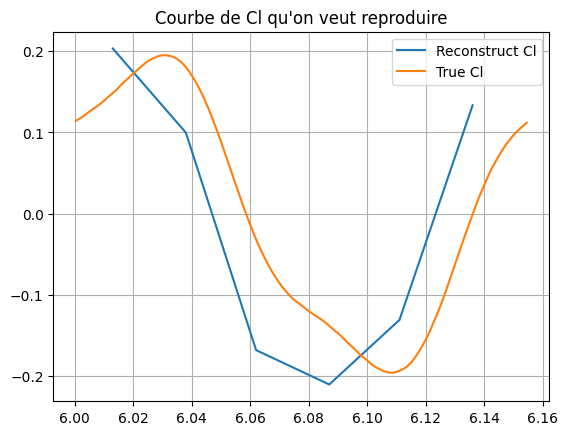

In [34]:
plt.plot(time_1, cl_1, label="Reconstruct Cl")
plt.plot(time, cl_true, label='True Cl')
plt.grid()
plt.legend()
plt.title("Courbe de Cl qu'on veut reproduire")

In [35]:
# On essaye maintenant avec plus de points

nb_period = 27

In [36]:
masque = masque_close & (t>time_init) & (t<time_init + nb_period * T)

In [37]:
x_close = x[masque]
y_close = y[masque]
t_close = t[masque]
p_close = p[masque]

In [92]:
t_modulo = time_init + (t_close - time_init) % T

In [93]:
np.unique(t_modulo).shape

(170,)

In [94]:
np.unique(t_close).shape

(170,)

In [104]:
# On calcule Cl à chaque pas de temps quand meme :
cl_2 = []
time_2 = []
for time_ in np.unique(t_modulo):
    masque_time = (t_modulo == time_)
    theta = np.atan2(y_close[masque_time], x_close[masque_time])
    indice = np.argsort(theta)[::-1]
    d_theta = (theta[indice][:-1] - theta[indice][1:]).mean()
    f_portance = -np.sum(np.sin(theta[indice]) * p_close[masque_time][indice] * r * d_theta)
    cl_2.append(f_portance / (0.5 * rho * (V**2) * 2 * r))
    time_2.append(t_modulo[masque_time][indice][0])

In [102]:
d_theta

np.float64(0.040276895153101316)

Text(0.5, 1.0, "Courbe de Cl qu'on veut reproduire")

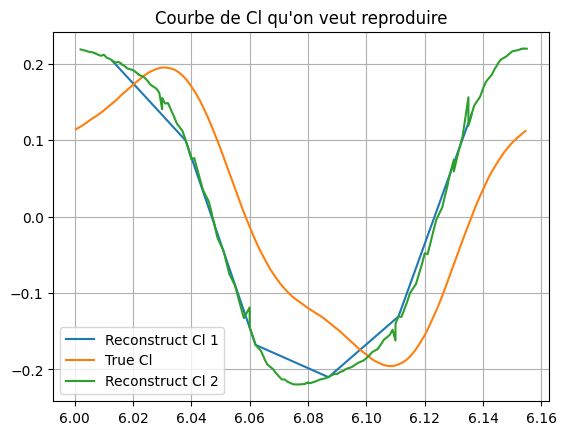

In [103]:
plt.plot(time_1, cl_1, label="Reconstruct Cl 1")
plt.plot(time, cl_true, label='True Cl')
plt.plot(time_2, cl_2, label="Reconstruct Cl 2")
plt.grid()
plt.legend()
plt.title("Courbe de Cl qu'on veut reproduire")

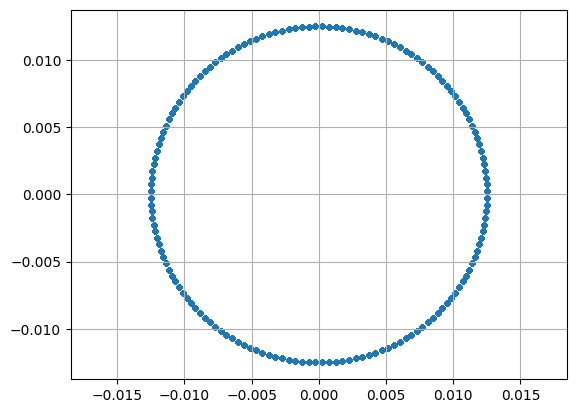

In [85]:
plt.scatter(x_close, y_close, marker='.')
plt.axis('equal')
plt.grid()

In [ ]:
# On test pour un cylindre avec deux pressions :

In [49]:
P_up = 1.
P_down = 0.

In [54]:
cl_3 = []
time_3 = []
for time_ in np.unique(t_modulo):
    masque_time = (t_modulo == time_)
    theta = np.atan2(y_close[masque_time], x_close[masque_time])
    indice = np.argsort(theta)[::-1]
    d_theta = (theta[indice][:-1] - theta[indice][1:]).mean()
    p_piche = ((theta > 0.) & (theta < np.pi)) * P_up
    f_portance = -np.sum(np.sin(theta[indice]) * p_piche[indice] * r * d_theta)
    cl_3.append(f_portance / (0.5 * rho * (V**2) * 2 * r))
    time_3.append(t_modulo[masque_time][indice][0])

In [ ]:
plt.plot()

In [53]:
(0.5 * rho * (V**2) * 2 * r)

0.015

np.float64(-1.6667821401831715)

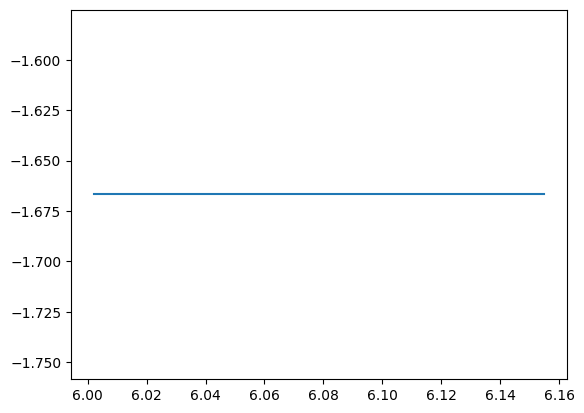

In [56]:
plt.plot(time_3, cl_3)
cl_3[0]

In [47]:
np.array([True, False])*8.

array([8., 0.])

In [1]:
########## On lit les normaux 

In [4]:
df = pd.read_csv('data/data_john_1_case_1.csv')

In [ ]:
df = pd.read_csv('data/data_john_1_case_1.csv')